In [1]:
# 0. Settings
# !pip install laion-clap
# !pip install torch
# !pip install torchvision
# !pip install torchaudio
import laion_clap
import glob
import json 
import torch
import numpy as np
import torchaudio
import tarfile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import os
import glob
import tensorflow as tf
from tensorflow import keras
import pickle


In [2]:
keras.backend.clear_session()

# Define Classifier type

In [3]:
class_index_dict_path = 'label/drumsc.json'
column_name = 'Instrument' # 'genre', 'artist'

# Load Dataset

In [4]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
        print(type(values))
    return values

In [5]:
clap_audio_embeds = load_pickle('data/clap_audio_embeds.pkl')
train_audio_embeds = load_pickle('data/dtrain_audio_embeds.pkl')
train_ground_truth_idx = load_pickle('data/dtrain_ground_truth_idx.pkl')
test_audio_embeds = load_pickle('data/dtest_audio_embeds.pkl')
test_ground_truth_idx = load_pickle('data/dtest_ground_truth_idx.pkl')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>


In [7]:
train_ground_truth = np.array(train_ground_truth_idx)
test_ground_truth = np.array(test_ground_truth_idx)
print(train_ground_truth.shape,test_ground_truth.shape)

(1408,) (30,)


In [8]:
print(clap_audio_embeds.shape,train_audio_embeds.shape,train_ground_truth.shape)
print(test_audio_embeds.shape,test_ground_truth.shape)
print(type(clap_audio_embeds),type(train_audio_embeds),type(train_ground_truth))

(50, 512) (1408, 512) (1408,)
(30, 512) (30,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Modeling (1) - Input : train_audio_embeds

Epoch 1/50
80/80 [==============================] - 1s 5ms/step - loss: 0.8112 - accuracy: 0.7111 - val_loss: 1.5182 - val_accuracy: 0.0284
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 0.3419 - accuracy: 0.8887 - val_loss: 1.4753 - val_accuracy: 0.0426
Epoch 3/50
80/80 [==============================] - 0s 4ms/step - loss: 0.2796 - accuracy: 0.9077 - val_loss: 1.3443 - val_accuracy: 0.1844
Epoch 4/50
80/80 [==============================] - 0s 4ms/step - loss: 0.2501 - accuracy: 0.9163 - val_loss: 1.1266 - val_accuracy: 0.4539
Epoch 5/50
80/80 [==============================] - 0s 4ms/step - loss: 0.2116 - accuracy: 0.9305 - val_loss: 0.8297 - val_accuracy: 0.6028
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 0.1823 - accuracy: 0.9440 - val_loss: 0.4881 - val_accuracy: 0.8582
Epoch 7/50
80/80 [==============================] - 0s 4ms/step - loss: 0.1793 - accuracy: 0.9487 - val_loss: 0.2732 - val_accuracy: 0.8936
Epoch 8/50
80/80 [==

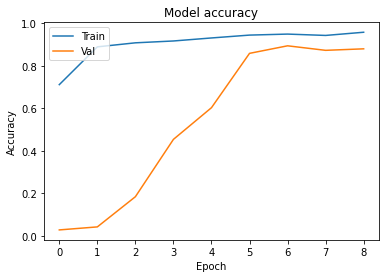

In [40]:
import numpy as np
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
np.random.seed(42)
tf.random.set_seed(42)

# Define the model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=train_audio_embeds.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

# model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=2)

# Train the model
history = model.fit(train_audio_embeds, train_ground_truth, validation_split=0.1, epochs=50, batch_size=16, callbacks=[early_stop]) #32

import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [41]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_audio_embeds, test_ground_truth)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


1/1 [==============================] - 0s 18ms/step - loss: 0.5668 - accuracy: 0.8000
Test loss: 0.5668043494224548
Test accuracy: 0.800000011920929


<AxesSubplot:>

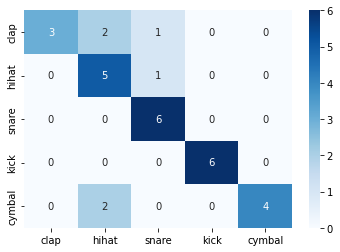

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on test data
test_predictions = model.predict(test_audio_embeds).argmax(axis=-1)

# Compute confusion matrix
cm = confusion_matrix(test_ground_truth, test_predictions)

# Plot confusion matrix

class_names = ['clap', 'hihat', 'snare', 'kick', 'cymbal']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)